# WinoAPH_Climate
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key
from api_keys import meteostat_api_key

# Output File (CSV)
output_data_file = "../Output/wine_cleaned_location.csv"


## Generate Province & Variety Lists

In [2]:
df = pd.read_csv(output_data_file)
climate_df= df.drop(columns=['description', 'taster_name', 'taster_twitter_handle', 'title'])
#grouped_global_data = climate_df.groupby(['country', 'province'])
climate_df.head()

,country,points,price,province,region_1,variety,winery,Wine_Year,latitude,longitude
0,Italy,87,NaN,Sicily & Sardinia,Etna,White Blend,Nicosia,2013,37.599994,14.015356
1,Portugal,87,15.0,Douro,NaN,Portuguese Red,Quinta dos Avidagos,2011,41.501277,-5.512293
2,US,87,14.0,Oregon,Willamette Valley,Pinot Gris,Rainstorm,2013,43.804133,-120.554201
3,US,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian,2013,44.314844,-85.602364
4,US,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks,2012,43.804133,-120.554201


In [3]:
wine_climate_df = climate_df[["country", "province", "Wine_Year","points","price","variety","latitude", "longitude"]]

#first filter = unique province

ten_yr = wine_climate_df.loc[(wine_climate_df["Wine_Year"] > 2005) & (wine_climate_df["Wine_Year"] < 2017)]
wine_grouping = ten_yr.dropna()
#wine_grouping.drop_duplicates(subset='province', keep='first', inplace=True)
#wine_dedup = pd.DataFrame(wine_grouping)

#second filter = top 2 varieties

top3_prov = wine_grouping.loc[wine_grouping['province'].isin(['Bordeaux', 'Burgundy','Alsace','California','Washington','Oregon','Tuscany','Piedmont','Veneto'])]
top3_prov = top3_prov.rename(columns={'Wine_Year': 'year'})
#top3_prov

top3_prov


,country,province,year,points,price,variety,latitude,longitude
2,US,Oregon,2013,87,14.0,Pinot Gris,43.804133,-120.554201
4,US,Oregon,2012,87,65.0,Pinot Noir,43.804133,-120.554201
7,France,Alsace,2012,87,24.0,Gewürztraminer,48.318179,7.441624
9,France,Alsace,2012,87,27.0,Pinot Gris,48.318179,7.441624
10,US,California,2011,87,19.0,Cabernet Sauvignon,36.778261,-119.417932
...,...,...,...,...,...,...,...,...
129896,France,Alsace,2010,90,57.0,Pinot Gris,48.318179,7.441624
129902,France,Alsace,2013,90,28.0,Pinot Gris,48.318179,7.441624
129905,France,Alsace,2013,90,30.0,Gewürztraminer,48.318179,7.441624
129906,France,Alsace,2012,90,32.0,Pinot Gris,48.318179,7.441624


In [4]:
weather_station = {
    'province': ['Bordeaux', 'Burgundy','Alsace','California','Washington','Oregon','Tuscany','Piedmont','Veneto'], 
    'weather station': ['07510', '07280','07190','72389','72797','72692','72694','06717','16098']}
df = pd.DataFrame(weather_station)

top3_ws = pd.merge(top3_prov, df, on="province",how="right")
    
top3_ws


,country,province,year,points,price,variety,latitude,longitude,weather station
0,US,Oregon,2013,87,14.0,Pinot Gris,43.804133,-120.554201,72692
1,US,Oregon,2012,87,65.0,Pinot Noir,43.804133,-120.554201,72692
2,US,Oregon,2013,87,20.0,Pinot Noir,43.804133,-120.554201,72692
3,US,Oregon,2010,86,50.0,Pinot Noir,43.804133,-120.554201,72692
4,US,Oregon,2009,86,22.0,Pinot Noir,43.804133,-120.554201,72692
...,...,...,...,...,...,...,...,...,...
63150,Italy,Veneto,2010,88,26.0,"Corvina, Rondinella, Molinara",45.441466,12.315259,16098
63151,Italy,Veneto,2009,88,36.0,"Corvina, Rondinella, Molinara",45.441466,12.315259,16098
63152,Italy,Veneto,2008,88,50.0,"Corvina, Rondinella, Molinara",45.441466,12.315259,16098
63153,Italy,Veneto,2009,88,25.0,"Corvina, Rondinella, Molinara",45.441466,12.315259,16098


#
## Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the province number and province name).


In [8]:
stations = ['07280']
response = []
temp = []
prec = []
month = []
record_num = 0
record_set = 1

# loops for creating dataframe columns
print("------------------------------\nBeginning Data Retrieval\n------------------------------")

for station in stations: 
    try:
        
        #station = row['weather station']
        query = f"https://api.meteostat.net/v1/history/monthly?station={station}&start=2006-01&end=2015-12&key={meteostat_api_key}"
        response = requests.get(query).json()   
        #print(response)
        for x in range(120):
            temp.append(response['data'][x]["temperature_mean"])
            prec.append(response['data'][x]['precipitation'])
            month.append(response['data'][x]["month"])
            print(response['data'][x]["temperature_mean"])
            print(response['data'][x]["precipitation"])
            print(response['data'][x]["month"])
        #top3_ws.loc[index, 'Temperature'] = response['data']['temperature_mean']
        #print(f"Processing Record {record_num} of Set {record_set} | {row['weather station']}") 
        #print(f'The avg temperature for {station} is {response["temperature_mean"]}')
    except (KeyError, IndexError):
        print("Province not found. Skipping...")
          
print("------------------------------\nData Retrieval Complete\n------------------------------")


------------------------------
Beginning Data Retrieval
------------------------------
-0.2
50
2006-01
1.5
58
2006-02
5.2
129
2006-03
10
67
2006-04
14.1
109
2006-05
19.1
34
2006-06
24.7
32
2006-07
17.1
73
2006-08
18.6
39
2006-09
14
73
2006-10
7.8
39
2006-11
3.2
24
2006-12
5.3
61
2007-01
6.4
61
2007-02
6.9
67
2007-03
14.7
2
2007-04
15.6
80
2007-05
18.5
110
2007-06
18.7
119
2007-07
18.2
105
2007-08
14.4
51
2007-09
10.6
27
2007-10
5.2
53
2007-11
1.6
53
2007-12
3.8
62
2008-01
5
20
2008-02
6.1
69
2008-03
9.1
103
2008-04
15.9
81
2008-05
17.8
86
2008-06
19.8
58
2008-07
18.6
104
2008-08
13.8
58
2008-09
10.2
100
2008-10
6.4
56
2008-11
2.1
55
2008-12
-1
37
2009-01
2.5
70
2009-02
6.7
26
2009-03
12.1
71
2009-04
16.3
45
2009-05
18.1
91
2009-06
19.9
138
2009-07
21.1
37
2009-08
16.8
41
2009-09
10.4
34
2009-10
8.2
93
2009-11
2.9
80
2009-12
-0.5
33
2010-01
2.9
63
2010-02
6.1
45
2010-03
11.2
47
2010-04
12.7
50
2010-05
18.2
122
2010-06
21.4
69
2010-07
18.5
97
2010-08
14.3
60
2010-09
10.3
62
2010-10
6.6
9

In [9]:
climate_dict = {
    "weather station": station,
    "month": month,
    "temperature": temp,
    "precipipation": prec
}
climate_data = pd.DataFrame(climate_dict)
climate_data['year'] = pd.DatetimeIndex(climate_data['month']).year
year = climate_data['year']
annual_temp = climate_data.groupby('year')['temperature'].mean()
annual_precip = climate_data.groupby('year')['precipipation'].mean()
summary_df = pd.DataFrame({"Annual Temperature": annual_temp, "Annual Precipitation": annual_precip, "Weather Station": station})
summary_df



,Annual Temperature,Annual Precipitation,Weather Station
year,,,
2006,11.258333,60.583333,07280
2007,11.341667,65.750000,07280
2008,10.716667,71.000000,07280
2009,11.166667,63.583333,07280
2010,10.183333,71.083333,07280
2011,11.808333,55.166667,07280
2012,11.058333,65.000000,07280
2013,10.450000,81.166667,07280
2014,12.116667,68.000000,07280


In [10]:
Burgundy= top3_ws.loc[top3_ws['province'].isin(['Burgundy'])]
Burgundy_top3 = pd.merge(summary_df, Burgundy, on="year")
Burgundy_df = Burgundy_top3[["country", "province", "year","points","price","variety","Annual Temperature","Annual Precipitation","Weather Station"]]
Burgundy_top3.to_csv("../Output/Burgundy_top3.csv")
Burgundy_df

,country,province,year,points,price,variety,Annual Temperature,Annual Precipitation,Weather Station
0,France,Burgundy,2006,88,27.0,Chardonnay,11.258333,60.583333,07280
1,France,Burgundy,2006,87,35.0,Chardonnay,11.258333,60.583333,07280
2,France,Burgundy,2006,86,22.0,Chardonnay,11.258333,60.583333,07280
3,France,Burgundy,2006,90,58.0,Chardonnay,11.258333,60.583333,07280
4,France,Burgundy,2006,94,67.0,Chardonnay,11.258333,60.583333,07280
...,...,...,...,...,...,...,...,...,...
2857,France,Burgundy,2015,88,20.0,Chardonnay,11.975000,47.750000,07280
2858,France,Burgundy,2015,88,22.0,Chardonnay,11.975000,47.750000,07280
2859,France,Burgundy,2015,90,33.0,Chardonnay,11.975000,47.750000,07280
2860,France,Burgundy,2015,91,30.0,Chardonnay,11.975000,47.750000,07280


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [13]:
#Clean dataframe to remove lon & lat that were not found
Tus_Pied_Ore_Was_Cal_Als_Bur_Bord_Ven_df = Burgundy_df.append(Tus_Pied_Ore_Was_Cal_Als_Bur_Bord_Ven_df)


#Preview the dataframe & save to CSV
Tus_Pied_Ore_Was_Cal_Als_Bur_Bord_Ven_df.to_csv("../Output/top3.csv")
climate_top3 = Tus_Pied_Ore_Was_Cal_Als_Bur_Bord_Ven_df

climate_top3

NameError: name 'Tus_Pied_Ore_Was_Cal_Als_Bur_Bord_Ven_df' is not defined

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### All Provinces - Temperature vs. Wine Score Plot
####  All Provinces - Humidity vs. Wine Score Plot
####  Pinot Noir - Temperature vs. Wine Score Plot
####  Pinot Noir - Humidity vs. Wine Score Plot
####  Chardonnay - Temperature vs. Wine Score Plot
####  Chardonnay - Humidity vs. Wine Score Plot

In [61]:
# Collect the mean annual temp, precipitation, and points
#Avg_Temp = climate_top3.groupby('year')['Annual Temperature'].mean()
#Avg_Precip = climate_top3.groupby('year')['Annual Precipitation'].mean()
#Avg_Pt = climate_top3.groupby('year')['points'].mean()

output_data_file = "../Output/top3_final.csv"
df = pd.read_csv(output_data_file)

#France_df = df.loc[df["country"]== "France",:]
#US_df = df.loc[climate_top3["country"]== "US",:]
#Italy_df = df.loc[climate_top3["country"]== "Italy",:]

#province_df = df.groupby(['country','province','year'])
#province_df2 = province_df["points"].mean().to_frame(name = 'avg_points').reset_index()

f = {'points': 'mean', 'Annual Temperature': 'mean','Annual Precipitation': 'mean'}
province_df2 = df.groupby(['country','province','year'], as_index=False).agg(f)

#province_data["points"].mean()
#pd.DataFrame
province_df2

,country,province,year,points,Annual Temperature,Annual Precipitation
0,France,Alsace,2006,87.857143,11.233333,56.583333
1,France,Alsace,2007,88.854167,11.500000,60.416667
2,France,Alsace,2008,89.690909,10.983333,55.083333
3,France,Alsace,2009,88.987013,11.116667,53.500000
4,France,Alsace,2010,89.932773,10.033333,66.416667
...,...,...,...,...,...,...
77,US,Washington,2011,89.002353,8.816667,227.500000
78,US,Washington,2012,89.402894,9.533333,253.000000
79,US,Washington,2013,89.100079,10.808333,187.750000
80,US,Washington,2014,88.783349,10.958333,222.666667


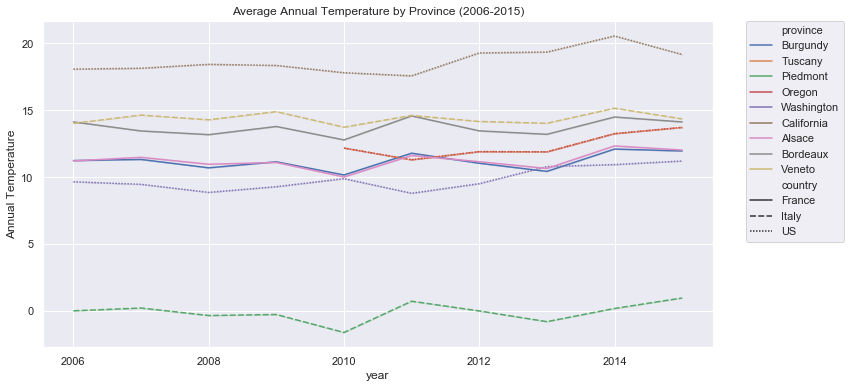

In [74]:
import seaborn as sns
plt.figure(figsize=(12,6))
ax = sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax = sns.lineplot(x="year", y="Annual Temperature",
             hue="province",style="country",
             data=df)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Average Annual Temperature by Province (2006-2015)')
ax.figure.savefig('../img_ca/fig_APH01.png')

Text(0.5, 1.0, 'Average Annual Precipitation by Province (2006-2015)')

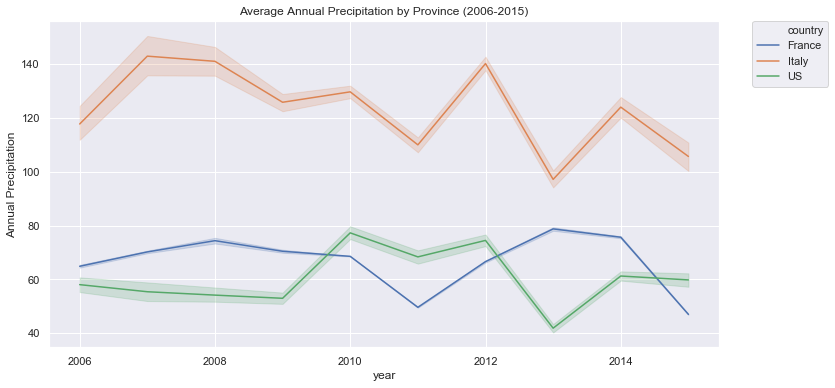

In [113]:
plt.figure(figsize=(12,6))
ax = sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax = sns.lineplot(x="year", y="Annual Precipitation",
             hue="country",
             data=df)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Average Annual Precipitation by Province (2006-2015)')
#ax.figure.savefig('../img_ca/fig_APH02.png')

Text(0.5, 1.0, 'Average Annual Points by Province (2006-2015)')

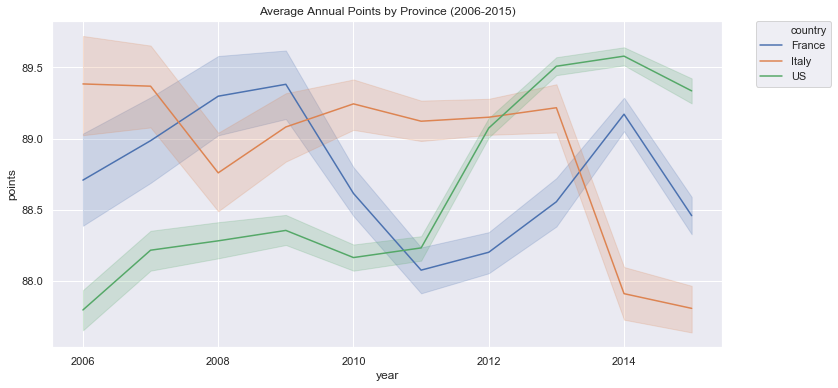

In [109]:
plt.figure(figsize=(12,6))
ax = sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax = sns.lineplot(x="year", y="points",
             hue="country",
             data=df)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Average Annual Points by Province (2006-2015)')
#ax.figure.savefig('../img_ca/fig_APH05.png')

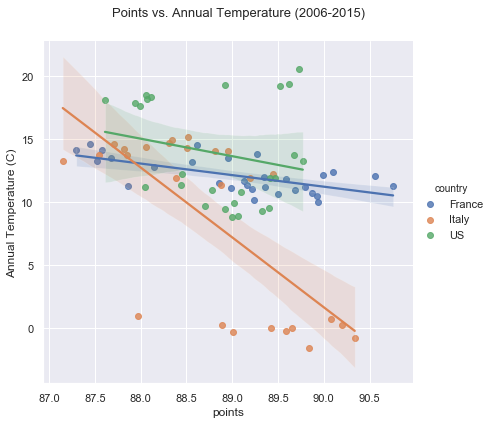

In [106]:
ax = sns.set(style="darkgrid")

ax = sns.lmplot(x="points", y="Annual Temperature", hue="country",
               height=6, data=province_df2)
#slope, intercept, r_value, p_value, std_err = stats.linregress(province_df2['points'], province_df2['Annual Temperature'])
# Use more informative axis labels than are provided by default
ax.set_axis_labels("points", "Annual Temperature (C)")
ax.fig.suptitle('Points vs. Annual Temperature (2006-2015)', fontsize=13)
ax = plt.subplots_adjust(top=.9)
plt.savefig('../img_ca/fig_APH03.png')

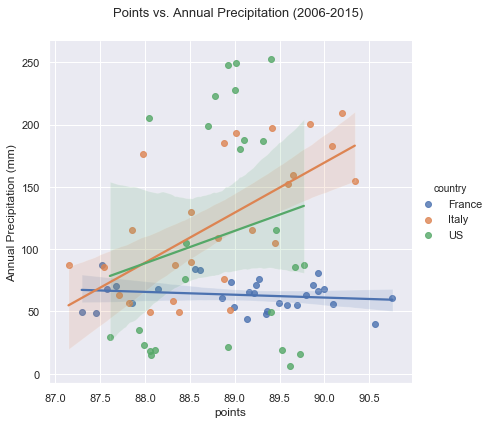

In [107]:
# Plot sepal width as a function of sepal_length across days
ax = sns.lmplot(x="points", y="Annual Precipitation", hue="country",
               height=6, data=province_df2)

# Use more informative axis labels than are provided by default
ax.set_axis_labels("points", "Annual Precipitation (mm)")
ax.fig.suptitle('Points vs. Annual Precipitation (2006-2015)', fontsize=13)
ax = plt.subplots_adjust(top=.9)
plt.savefig('../img_ca/fig_APH04.png')

# Figure 1
## conclusion
#### a;slkdfjsdj
* ;aslkdjf;lsdjf;sldjflsjdf;sdj
